In [166]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader, TensorDataset
import random
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
# Thus we have 60,000 images in training set and 10,000 images in the testing set
# each image is 28 x 28

In [168]:
# create a dataset class to init, get len and get item from dataset

class MnistDataset():
    def __init__(self):
        super().__init__()

        self.x_train = torch.tensor(np.load('x_train.npy'), dtype=torch.float32)
        self.y_train = torch.tensor(np.load('y_train.npy'), dtype=torch.long)

        self.x_test = torch.tensor(np.load('x_test.npy'), dtype=torch.float32)

    def __len__(self):
        # Return the length of the dataset
        return len(self.x_train)

    def __getitem__(self, index):
        # Return data and label at the given index
        return self.x_train[index], self.y_train[index]

In [169]:
#Plotting data to look at the nature of the images
def plotImage(data):
  image = data.reshape(28, 28)
  plt.imshow(image)
  plt.title(f'Label: {label}')
  plt.axis('off')
  plt.show()

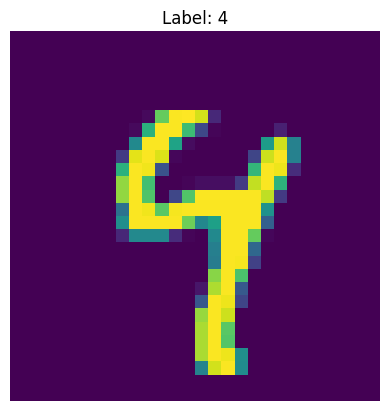

In [170]:
# see the labels appended
dataset = MnistDataset()
image, label = dataset[2]
plotImage(image)

In [171]:
len(dataset)

60000

In [172]:
#dataset[0]

# basically, loaded dataset had 2 components - (image, label)

In [173]:
# Creating a data loader - inputs are data, batch size, shuffle, validation size etc
# constructor will set batches, validation set etc
# further we define a split data function to create the train test split
# we also pre process the data as per the required size of images needed ie (-1,1,28,28)
# Further set batch iterations and lenght methods

class DataLoader():
    def __init__(self, dataset, batch_size=10, shuffle=True, validation_size=0.2, transform=None):
        super().__init__()

        self.batch_size = batch_size
        self.validation_size = validation_size
        self.ifShuffle = shuffle
        self.dataset = dataset
        self.transform = transform
        self.train_data, self.validation_data = self.split_data(validation_size)
        self.train_loader = torch.utils.data.DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.validation_loader = torch.utils.data.DataLoader(self.validation_data, batch_size=batch_size, shuffle=True)

    def split_data(self, validation_size):
        num_samples = len(self.dataset)
        num_validation_samples = int(validation_size * num_samples)
        num_train_samples = num_samples - num_validation_samples

        # Split the dataset into training and validation sets
        train_data, validation_data = torch.utils.data.random_split(self.dataset, [num_train_samples, num_validation_samples])

        return train_data, validation_data

    def preprocess_input(self, data):
        if self.transform:
            # Apply the transformation
            transformed_data = self.transform(data)

            # Check if the transformed data is already in 4D format
            if len(transformed_data.shape) == 4:
                return transformed_data
            else:
                # Reshape the transformed data to 4D if needed
                return transformed_data.view(-1, 1, 28, 28)  # Assuming images are 28x28 grayscale
        else:
            return data

    def __iter__(self):
        for batch in self.train_loader:
            yield self.preprocess_input(batch)

    def __len__(self):
        return len(self.train_loader)


In [174]:
# create an instance of the data loader class
data_loader = DataLoader(MnistDataset(), batch_size=10, shuffle=True, validation_size=0.2)

In [175]:
# create train and validation loader

train_loader = data_loader.train_loader
validation_loader = data_loader.validation_loader

In [176]:
# checking if 80-20 split happened correctly
len(train_loader)

4800

In [178]:
print("The Train loader has per batch",len(train_loader))
print("The Validation loader has per batch", len(validation_loader))

The Train loader has per batch 4800
The Validation loader has per batch 1200


In [179]:
# Visualize one digit in each example

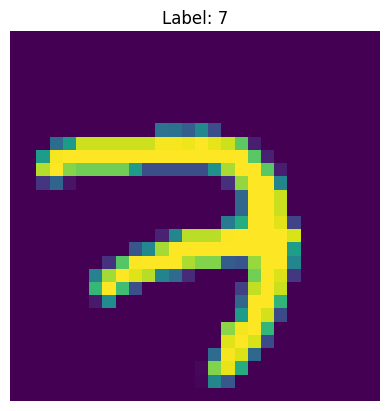

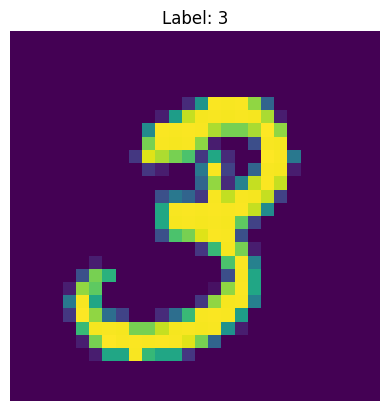

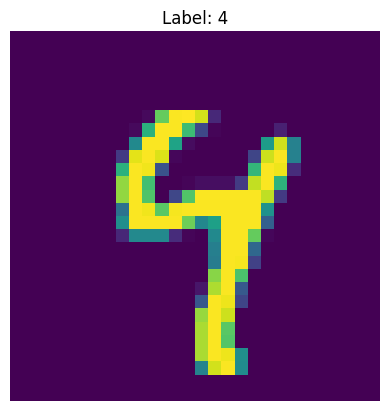

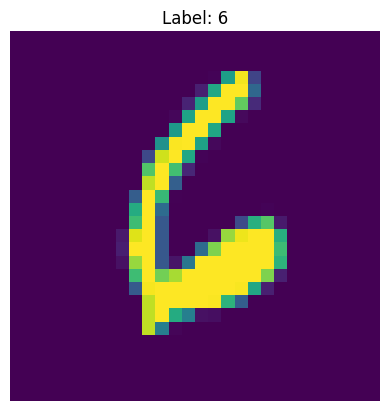

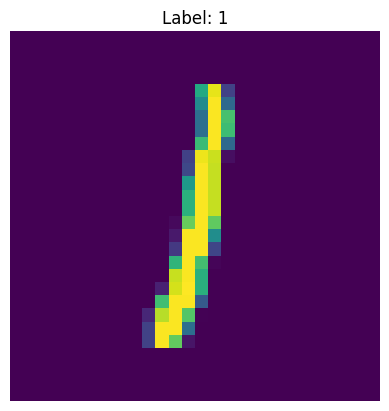

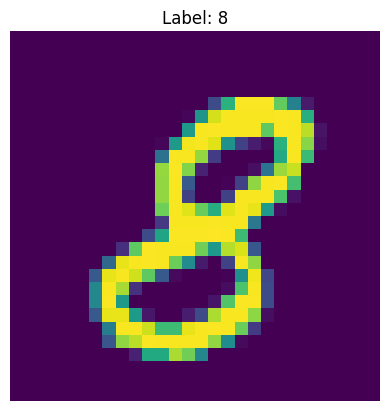

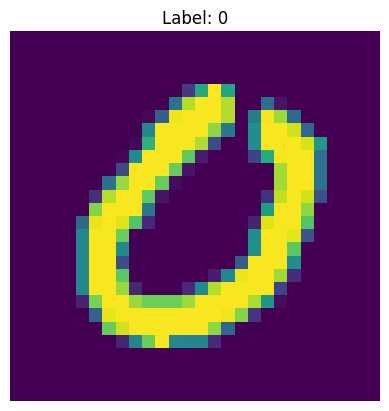

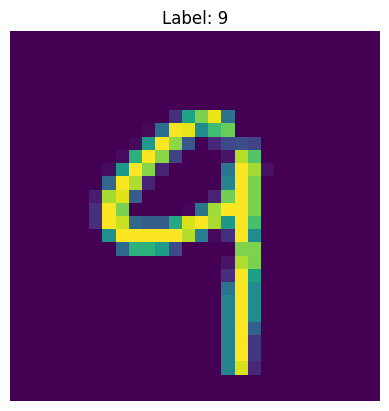

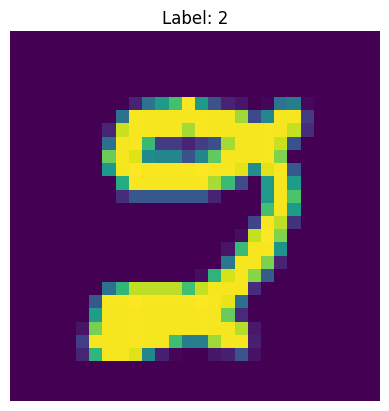

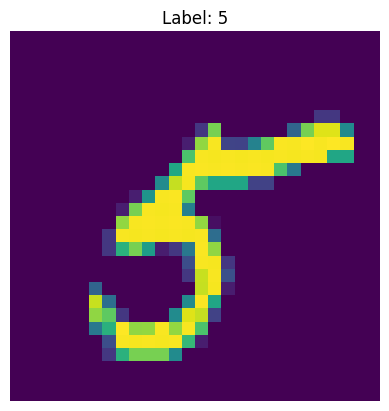

In [180]:
dataset = MnistDataset()

# iterate through the data till 10 distinct digit are encountered and then print them

countDigits, i = 0, 0
digitsVized = []
while countDigits <= 9 and i < len(dataset):
  img, label = dataset[i]
  if label not in digitsVized:
    digitsVized.append(label)
    plotImage(img)
    countDigits += 1
  i += 1

Label 0: 5923 samples
Label 1: 6742 samples
Label 2: 5958 samples
Label 3: 6131 samples
Label 4: 5842 samples
Label 5: 5421 samples
Label 6: 5918 samples
Label 7: 6265 samples
Label 8: 5851 samples
Label 9: 5949 samples


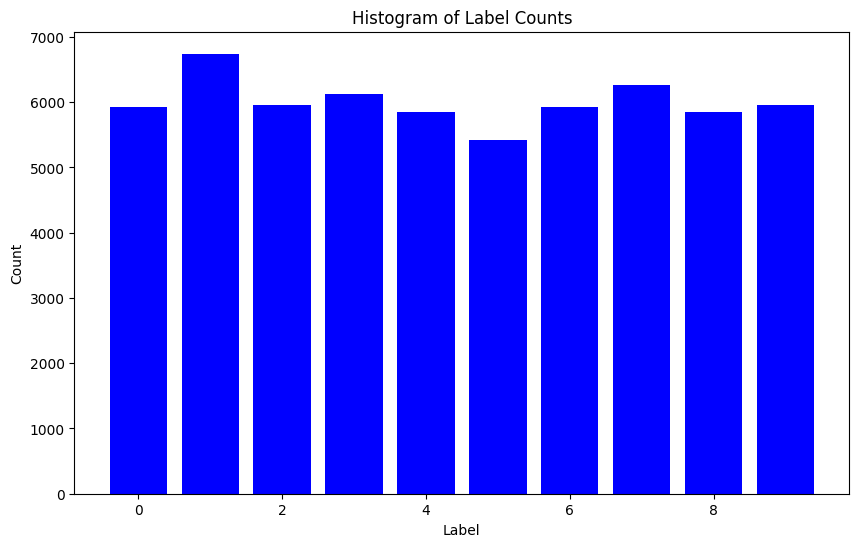

In [181]:
# Print and plot the number of each digit

all_labels = dataset.y_train

label_counts = torch.bincount(all_labels)

for label, count in enumerate(label_counts):
    print(f"Label {label}: {count} samples")

plt.figure(figsize=(10, 6))
plt.bar(range(len(label_counts)), label_counts, color='blue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Histogram of Label Counts')
plt.show()

In [182]:
# dataset looks balanced

In [183]:
# declaring a CNN model with filter size, batch normalization layer selections and activation function as hyper-parameters
# setting all layer parameters and # neurons
# calculating the input size needed for the linear layer based on the continuous CNN and pooling layers
  # eg. a 2x2 pooling layer will reduce the dimension to half for l as well as w and so on
# similarly then checking which layers are given for norm- i do batch normalizations
# In forward we set the layer sequencing

class CNNModel(nn.Module):
    def __init__(self, filter_size=3, batchNorm=["l1", "l2", "l3", "l4"], actFun="relu"):
        super().__init__()
        self.batchNorm = batchNorm
        self.activation_function = actFun
        self.StrideSize = 1
        self.out1 = 6
        self.out2 = 12
        self.out3 = 24
        self.out4 = 48
        self.dim = 28
        self.c1, self.c2 = 2, 2

        size_after_conv_layersc1 = self.dim - ((filter_size - self.StrideSize) * self.c1)
        size_after_pool1 = math.ceil(size_after_conv_layersc1 / 2)
        size_after_conv_layersc2 = size_after_pool1 - ((filter_size - self.StrideSize) * self.c2)
        self.size_after_pool2 = int(math.ceil(size_after_conv_layersc2 / 2))

        self.conv1 = nn.Conv2d(1, self.out1, filter_size, self.StrideSize)
        self.conv2 = nn.Conv2d(self.out1, self.out2, filter_size, self.StrideSize)
        self.conv3 = nn.Conv2d(self.out2, self.out3, filter_size, self.StrideSize)
        self.conv4 = nn.Conv2d(self.out3, self.out4, filter_size, self.StrideSize)

        self.fc1 = nn.Linear(48 * self.size_after_pool2 * self.size_after_pool2, 120)  # Adjusted input size here
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        if "l1" in self.batchNorm:
            self.batch_norm1 = nn.BatchNorm2d(6)
        if "l2" in self.batchNorm:
            self.batch_norm2 = nn.BatchNorm2d(12)
        if "l3" in self.batchNorm:
            self.batch_norm3 = nn.BatchNorm2d(24)
        if "l4" in self.batchNorm:
            self.batch_norm4 = nn.BatchNorm2d(48)

        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        if "l1" in self.batchNorm:
            x = self.batch_norm1(getattr(F, self.activation_function)(self.conv1(x)))
        else:
            x = getattr(F, self.activation_function)(self.conv1(x))
        x = getattr(F, self.activation_function)(self.conv2(x))
        if "l2" in self.batchNorm:
            x = self.batch_norm2(x)
        x = F.max_pool2d(x, 2, 2)

        if "l3" in self.batchNorm:
            x = self.batch_norm3(getattr(F, self.activation_function)(self.conv3(x)))
        else:
            x = getattr(F, self.activation_function)(self.conv3(x))
        x = getattr(F, self.activation_function)(self.conv4(x))
        if "l4" in self.batchNorm:
            x = self.batch_norm4(x)
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 48 * self.size_after_pool2 * self.size_after_pool2)  # Adjusted view size here

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))

        return F.log_softmax(x, dim=1)


In [184]:
import time

start_time = time.time()

epochs = 5
train_losses, test_losses = [], []
train_correct, test_correct = [], []

overalMaxAccuracy = 0
# Setting hyper parameters
# 1. set layers that we want to normalize - tune this
batchNormLayers = [["l1","l2","l3","l4","l5"], ["l1","l2"],["l1","l3","l5"]]
# 2. set activation functions to tune
actFuns = ["tanh", "relu"]
# 3. filter size to tune
filter_sizes = [5,3]
# run 3 loops - to perform tuning of the above three hyper parameters
for normLayers in batchNormLayers:
  for actFun in actFuns:
    for filter_size in filter_sizes:
      torch.manual_seed(41)
      # declare the model with each parameter picked by loop iteration
      model = CNNModel(filter_size, normLayers, actFun)
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

      for i in range(epochs):
          train_corr = 0
          test_corr = 0

          for b, (X_train, y_train) in enumerate(train_loader):
              # Reshape input data to 4D
              b += 1
              X_train = X_train.view(-1, 1, 28, 28)

              y_pred = model(X_train)
              loss = criterion(y_pred, y_train)
              # make predictions
              predicted = torch.max(y_pred.data, 1)[1]
              batch_corr = (predicted == y_train).sum()
              train_corr += batch_corr

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

              if b % 600 == 0:
                  print("epoch: ", i)
                  print("batch: ", b)
                  print("loss: ", loss.item())

          train_losses.append(loss)
          train_correct.append(train_corr)

          # Calculate training accuracy
          train_accuracy = train_corr.item() / len(train_loader.dataset)

          # Testing
          test_pred = []
          test_true = []
          with torch.no_grad(): # no training anymore
              for b, (X_test, y_test) in enumerate(validation_loader):
                  X_test = X_test.view(-1, 1, 28, 28)
                  y_val = model(X_test)
                  predicted = torch.max(y_val.data, 1)[1]
                  test_pred.extend(predicted.tolist())
                  test_true.extend(y_test.tolist())

              test_pred = torch.tensor(test_pred)
              test_true = torch.tensor(test_true)

          loss = criterion(y_pred, y_test)
          test_losses.append(loss)
          test_correct.append(torch.sum(test_pred == test_true))
          # Calculate testing accuracy
          test_accuracy = torch.sum(test_pred == test_true).item() / len(validation_loader.dataset)

          if test_accuracy > overalMaxAccuracy:
            bestModel = model
            overalMaxAccuracy = test_accuracy

          print("Using Normalization for layers: ",normLayers,"Activation Fucntion: ", actFun,"filter size: ", filter_size)
          print(f"Epoch {i+1}/{epochs}, Training Accuracy: {train_accuracy:.4f}, Testing Accuracy: {test_accuracy:.4f}")

current_time = time.time()
total_time = current_time - start_time
print("Training time: ", total_time/60, "mins")


epoch:  0
batch:  600
loss:  0.3809472620487213
epoch:  0
batch:  1200
loss:  0.45057934522628784
epoch:  0
batch:  1800
loss:  0.1342570185661316
epoch:  0
batch:  2400
loss:  0.24945572018623352
epoch:  0
batch:  3000
loss:  0.10938254743814468
epoch:  0
batch:  3600
loss:  0.07520169019699097
epoch:  0
batch:  4200
loss:  0.21922442317008972
epoch:  0
batch:  4800
loss:  0.03263983502984047
Using Normalization for layers:  ['l1', 'l2', 'l3', 'l4', 'l5'] Activation Fucntion:  tanh filter size:  5
Epoch 1/5, Training Accuracy: 0.8998, Testing Accuracy: 0.9607
epoch:  1
batch:  600
loss:  0.02268877625465393
epoch:  1
batch:  1200
loss:  0.1325637400150299
epoch:  1
batch:  1800
loss:  0.13833832740783691
epoch:  1
batch:  2400
loss:  0.04156896099448204
epoch:  1
batch:  3000
loss:  0.575682520866394
epoch:  1
batch:  3600
loss:  0.0416775718331337
epoch:  1
batch:  4200
loss:  0.011818056926131248
epoch:  1
batch:  4800
loss:  0.01193027663975954
Using Normalization for layers:  ['l1

In [185]:
# we got the best model from the loop - the one with best accuracy
bestModel

CNNModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=768, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (batch_norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.05, inplace=False)
)

In [186]:
# this is the best accuracy we got
overalMaxAccuracy

0.98925

In [188]:
# get predictions using best model

In [189]:
# get the test data loader
class TestLoader():
    def __init__(self, test_data, batch_size=10, shuffle=False, transform=None):
        self.batch_size = batch_size
        self.ifShuffle = shuffle
        self.test_data = test_data
        self.transform = transform
        self.test_loader = torch.utils.data.DataLoader(self.test_data, batch_size=batch_size, shuffle=shuffle)

    def preprocess_input(self, data):
      if self.transform:
          transformed_data = self.transform(data)
          if len(transformed_data.shape) == 4:
              # Ensure the number of channels is correct
              if transformed_data.shape[1] != 1:
                  # If not, convert to grayscale
                  transformed_data = torch.mean(transformed_data, dim=1, keepdim=True)
              return transformed_data
          else:
              return transformed_data.view(-1, 1, 28, 28)  # Assuming images are 28x28 grayscale
      else:
          return data


    def __iter__(self):
        for batch in self.test_loader:
            yield self.preprocess_input(batch)

    def __len__(self):
        return len(self.test_loader)



In [190]:
# Instantiate the TestLoader class with your test data
x_test = torch.tensor(np.load('x_test.npy'), dtype=torch.float32)

test_dataset = torch.utils.data.DataLoader(x_test, batch_size=10, shuffle=False)
# evaluation mode
bestModel.eval()
print(len(test_dataset))

1000


In [191]:
# make predictions
predictedAll = []
with torch.no_grad():
  for X_test in test_dataset:
    X_test = X_test.view(-1, 1, 28, 28)
    y_val = bestModel(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    predictedAll.append(predicted)

# Concatenate predictions from all batches
all_predictions = torch.cat(predictedAll, dim=0)

print(all_predictions.shape)  # Check the shape of all_predictions


torch.Size([10000])


In [192]:
# export the data to excel
finalPreds = pd.DataFrame(all_predictions, columns=["preds"])
finalPreds.to_csv("Joshi_Neha.csv", index=False)

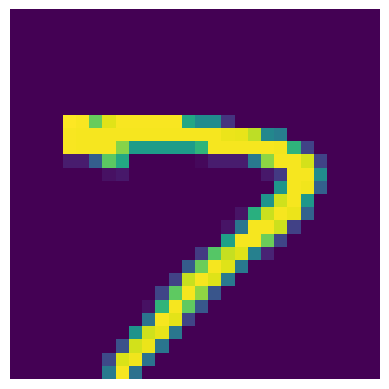

In [197]:
# pick a random image
data_loader = DataLoader(dataset)
dataset_length = len(dataset)

random_index = random.randint(0, dataset_length - 1)
random_image, _ = dataset[random_index]

random_image_numpy = random_image.numpy()

# Display the image
random_image_numpy = random_image_numpy.reshape(28, 28)

# Display the image
plt.imshow(random_image_numpy)
plt.axis('off')
plt.show()

torch.Size([6, 26, 26])
torch.Size([48, 20, 20])


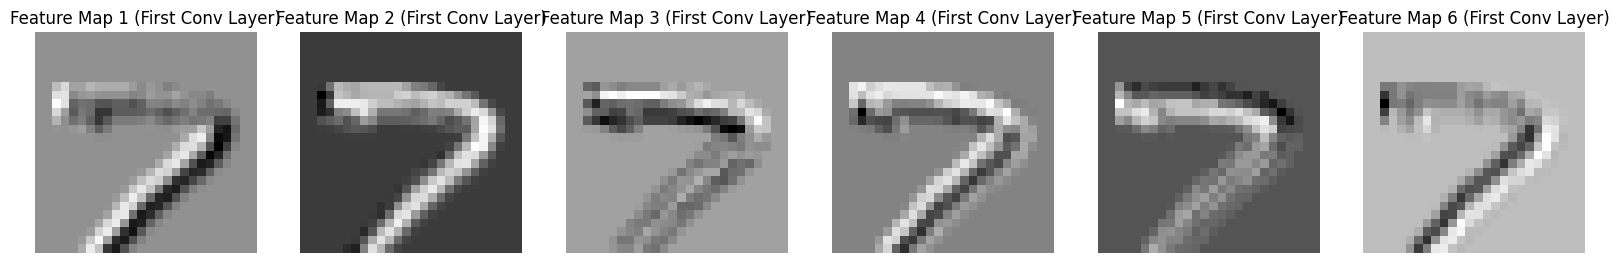

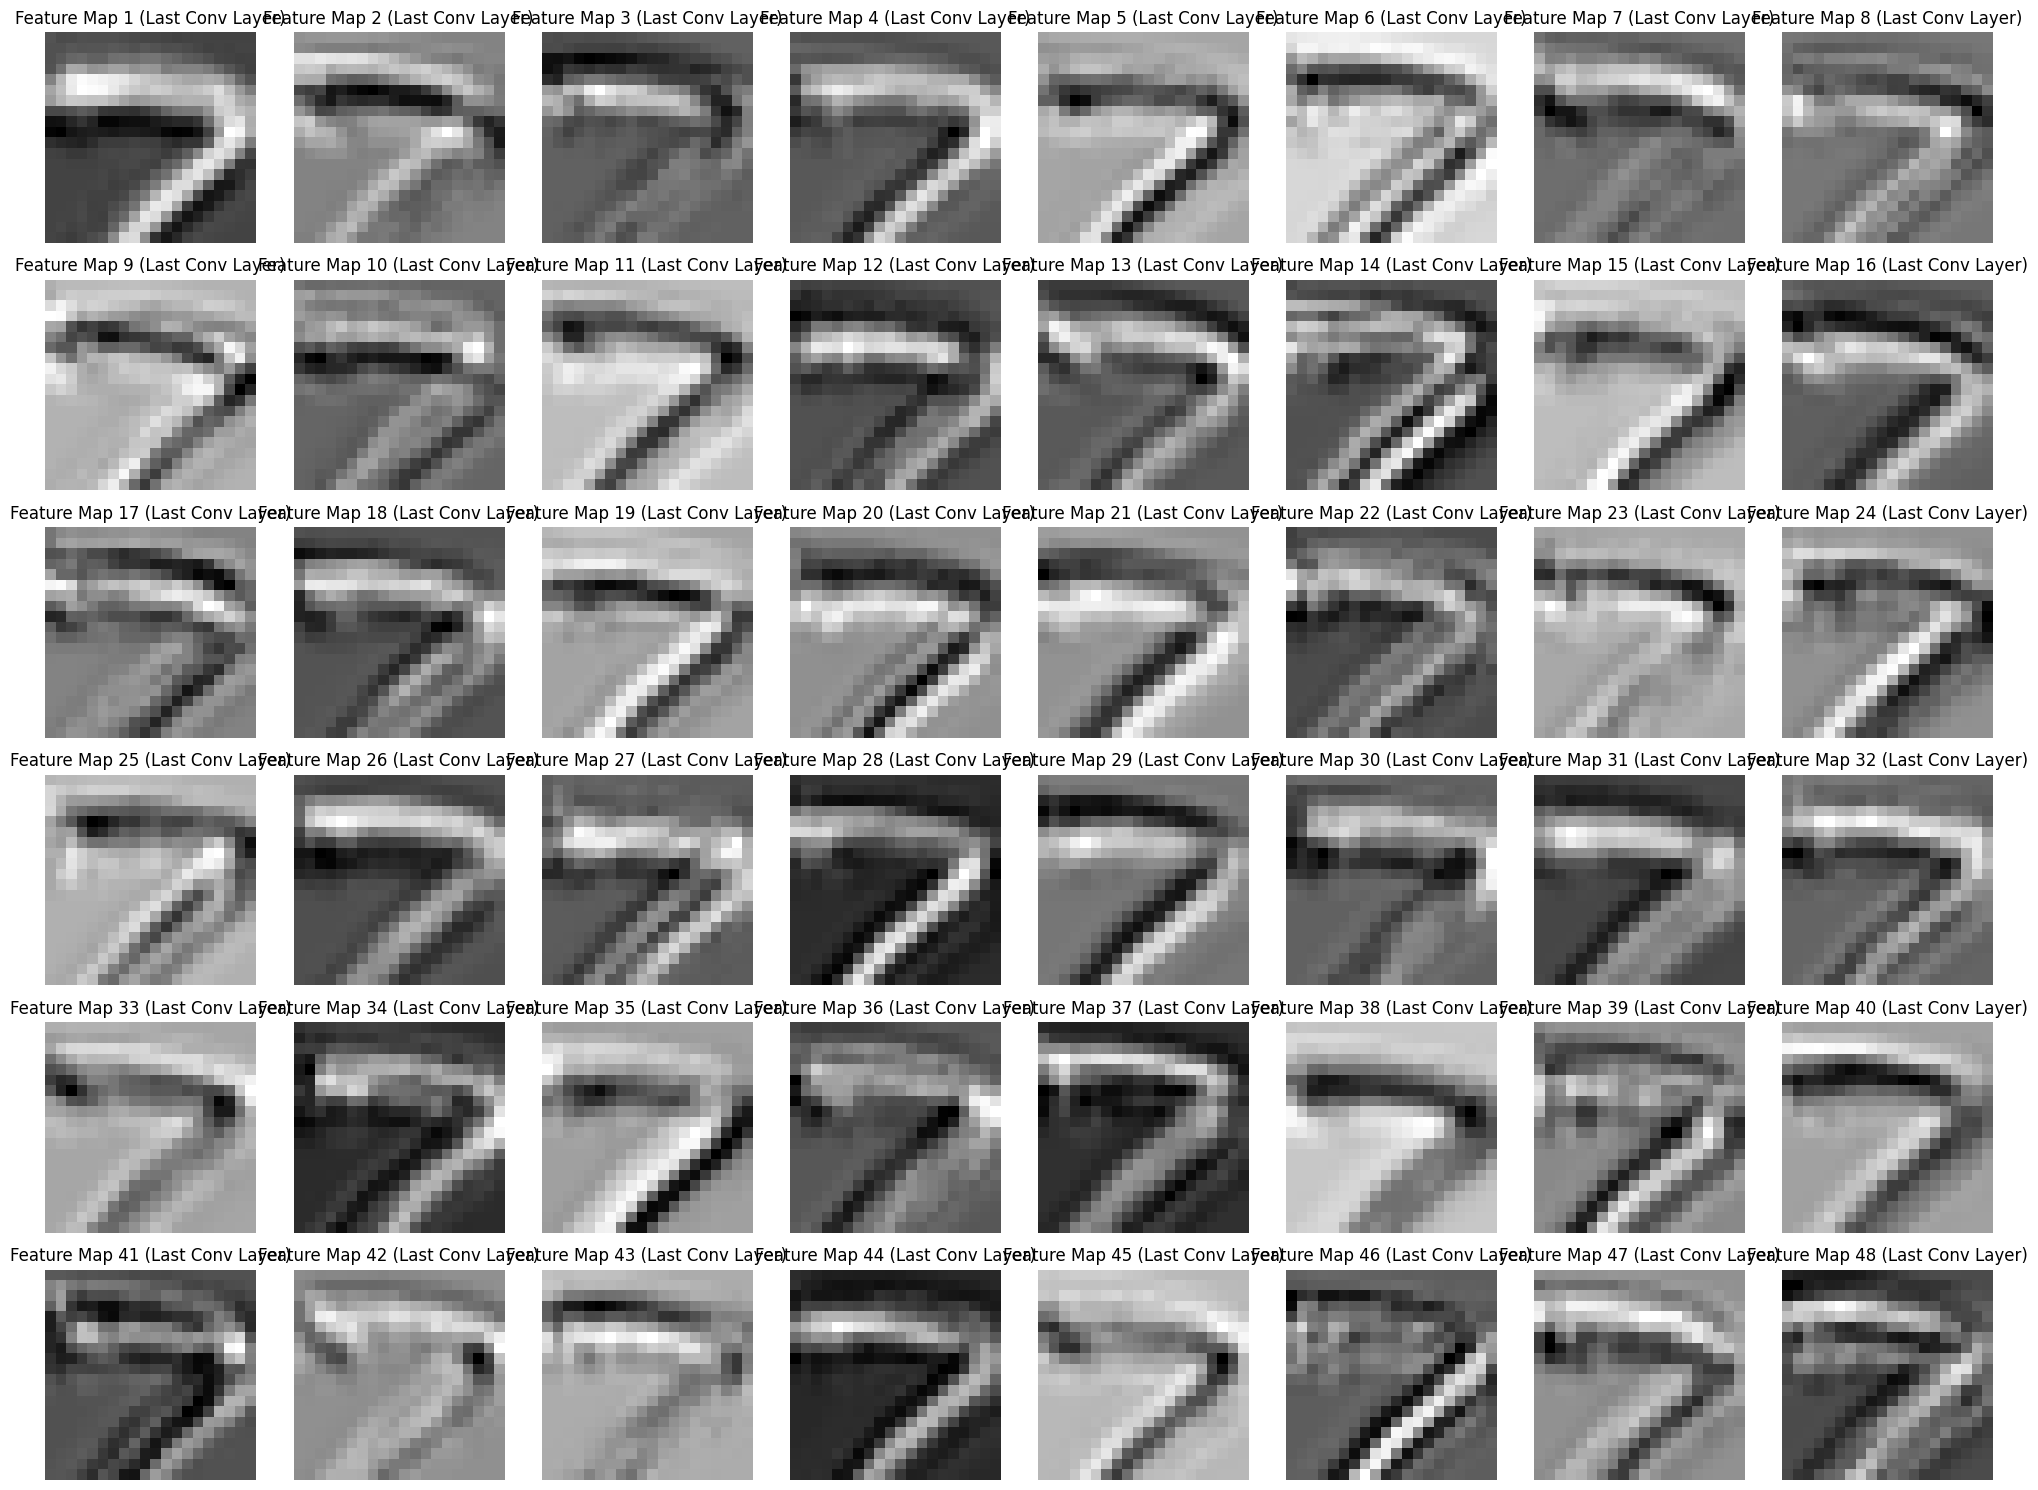

In [198]:
# get the first and last activation filter map
sample_image = random_image.view(28, 28)

# Create an instance of the CNNModel
model = bestModel

# Pass the sample image through the model
with torch.no_grad():
    model.eval()
    activations_first = model.conv1(sample_image.unsqueeze(0))
    activations_last = model.conv4(model.conv3(model.conv2(model.conv1(sample_image.unsqueeze(0)))))

print(activations_first.shape)
print(activations_last.shape)
num_rows = 6
num_cols = math.ceil(activations_last.size(0) / num_rows)

# Visualize feature maps for the first convolutional layer
fig, axes = plt.subplots(1, activations_first.size(0), figsize=(20, 5))
for i in range(activations_first.size(0)):
    axes[i].imshow(activations_first[i].detach().numpy(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Feature Map {i+1} (First Conv Layer)')
plt.show()

# Visualize feature maps for the last convolutional layer
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
for i in range(activations_last.size(0)):
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].imshow(activations_last[i].detach().numpy(), cmap='gray')
    axes[row_idx, col_idx].axis('off')
    axes[row_idx, col_idx].set_title(f'Feature Map {i+1} (Last Conv Layer)')
plt.tight_layout()
plt.show()


In [196]:
# EOF